In [41]:
%matplotlib notebook
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from sotodlib.io.load_smurf import (G3tSmurf, Observations, Tunes, TuneSets)

import sys

## Yes this should be packaged
dm_path = '/home/kmharrin/software/sodetlib/scratch/kaiwen/det_map/'
if dm_path not in sys.path:
    sys.path.append(dm_path)
import detector_map as det_map

## This houses temporary scripts we should move
## somewhere more permanent 
from latrt_testing import utils

In [6]:
SMURF = G3tSmurf(archive_path= '/mnt/so1/data/chicago-latrt/timestreams/',
                meta_path = '/mnt/so1/data/chicago-latrt/smurf/',
                db_path='/mnt/so1/users/kmharrin/smurf_context/latrt_db_v3.db')
session = SMURF.Session()

## LATRt Cooldown Information

We expect to see much larger shifts in resonator mapping between cool downs instead of during them. There are times where we were making a lot of TuneSets to check this (especially CD0) and other times where we were more focused on optical testing.
* CD0 : 5/12/21 - 5/29/21
* CD1 : 6/12/21 - 7/10/21
* CD2 : 8/13/21 - 9/5/21
* CD3 : 9/29/21 - 10/25/21

## Find interesting TuneSets

In [32]:
tunesets = session.query(TuneSets).filter(TuneSets.start >= dt.datetime(2021,5,1)).all()

## We have a mix of UFM and SPB tune files in the same stream_id right now
## filter out all but the ones that have the correct four bands
temp = []
ufm_cv4_tunesets = []

for ts in tunesets:
    if not np.all( [cha.band for cha in ts.chan_assignments] == [0,1,2,3]):
        continue
    temp.append(ts)

## filter out the tunesets we probably never streamed data on. I should
## probably add a check for this in building the database
for t  in range(len(temp)-1):
    if temp[t+1].start - temp[t].start > dt.timedelta(hours=1):
        ufm_cv4_tunesets.append(temp[t])
ufm_cv4_tunesets.append(temp[-1])

for ts in ufm_cv4_tunesets[-10:]:
    print(ts.start, ts.path)

2021-05-25 18:43:40 /mnt/so1/data/chicago-latrt/smurf/16219/crate1slot2/1621982463_setup_notches/outputs/1621982620_tune.npy
2021-05-27 17:03:19 /mnt/so1/data/chicago-latrt/smurf/16221/crate1slot2/1622149239_setup_notches/outputs/1622149399_tune.npy
2021-05-28 12:28:36 /mnt/so1/data/chicago-latrt/smurf/16222/crate1slot2/1622219156_setup_notches/outputs/1622219316_tune.npy
2021-06-14 13:28:55 /mnt/so1/data/chicago-latrt/smurf/16236/crate1slot2/1623691583_setup_notches/outputs/1623691735_tune.npy
2021-08-13 17:54:19 /mnt/so1/data/chicago-latrt/smurf/16288/crate1slot2/1628891495_setup_notches/outputs/1628891659_tune.npy
2021-09-30 15:53:39 /mnt/so1/data/chicago-latrt/smurf/16330/crate1slot2/1633031612_setup_notches/outputs/1633031619_tune.npy
2021-10-01 16:37:22 /mnt/so1/data/chicago-latrt/smurf/16331/crate1slot2/1633120517_setup_notches/outputs/1633120642_tune.npy
2021-10-01 18:16:37 /mnt/so1/data/chicago-latrt/smurf/16331/crate1slot2/1633126425_setup_notches/outputs/1633126597_tune.npy


## Load Tune File Data

In [95]:
## load the VNA and Channel Assignment info from the Tune File
tuneset = ufm_cv4_tunesets[0]
smurf_vna_results = utils.load_tune_find_freq(tuneset.path, bands=[0,1,2,3])
## this channel assignment information is also in the database
smurf_channel_assignment = utils.load_tune_channel_info(tuneset.path, bands=[0,1,2,3])

<IPython.core.display.Javascript object>


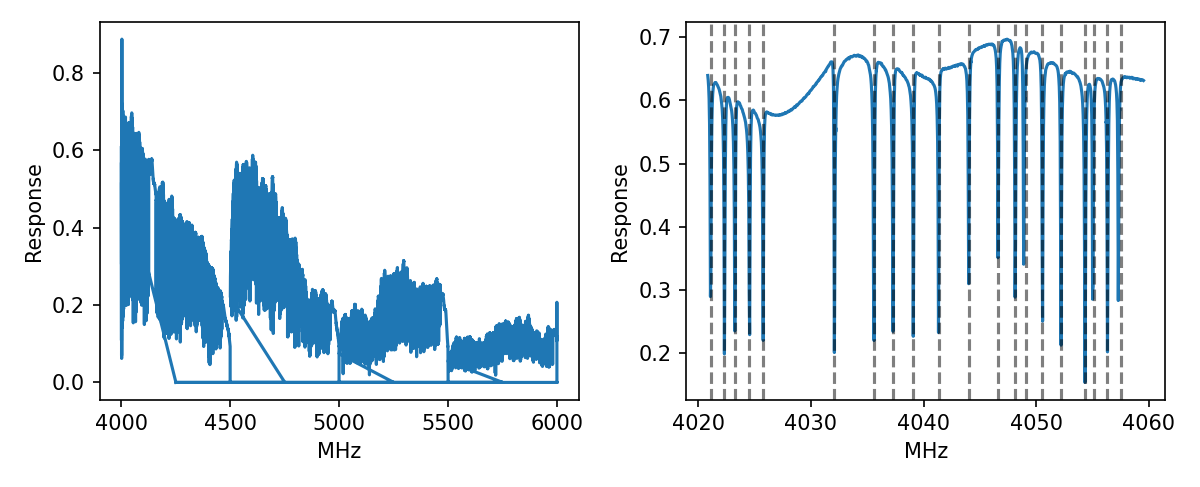

In [151]:
fig = plt.figure(figsize=(8,3.25))
plt.subplot(1,2,1)
plt.plot( smurf_vna_results[0], smurf_vna_results[1])
plt.xlabel('MHz'); plt.ylabel('Response')
plt.subplot(1,2,2)

plt.plot( smurf_vna_results[0][2000:3000], smurf_vna_results[1][2000:3000])

f0 = np.min(smurf_vna_results[0][2000:3000])
f1 = np.max(smurf_vna_results[0][2000:3000])

msk = np.all([smurf_channel_assignment['freq'] >= f0,
              smurf_channel_assignment['freq'] <= f1], axis=0)
y0,y1 = plt.ylim()
for ff in smurf_channel_assignment['freq'][msk]:
    plt.plot( [ff,ff], [y0,y1], 'k--', alpha=0.5)
    
plt.ylim(y0,y1)
plt.xlabel('MHz'); plt.ylabel('Response')
fig.tight_layout()

## Extract the Realized Resonator Frequencies

In [140]:
ufm_cv4_position_file = dm_path + 'Cv4/band2posn.csv'
ufm_cv4_design_file = dm_path + 'metadata/umux_32_map.pkl'
ufm_cv4_wafer_file = dm_path + "metadata/copper_map_corrected.csv"

In [129]:
## Matching will need to be split for the North coax and the South coax (because they have the same frequencies)
## UFM Cv4 only has the North coax working in the LATRt

"""Using Kaiwen's code
"""
N_ch_assigns = [cha.path for cha in tuneset.chan_assignments if ch.band <=3]
## ignoring this from now one because it's empty
S_ch_assigns = [cha.path for cha in tuneset.chan_assignments if ch.band >=4]

## This is just extracting information from the channel assignment files
N_smurf2freq = det_map.all_smurf_chan_to_realized_freq(N_ch_assigns)


"""How to do it with the G3tSmurf Database
(if statement needed because of old updating errors)
Frequency in the G3tSmurf Database is the realized frequency. 
    The one we expect to change each cooldown (and slightly between different Tunes)
"""
names, bands, channels, frequency = zip(* [(ch.name, ch.band, ch.channel, ch.frequency) 
                                          for ch_assign in tuneset.chan_assignments for ch in ch_assign.channels 
                                          if ch.channel != -1])
bands = np.array(bands)
channels = np.array(channels)
frequency = np.array(frequency)
## Move south frequencys down 
frequency[bands >= 4] -= 2000

## Double check these are equally
assert len(channels) == len(N_smurf2freq)
assert np.all( N_smurf2freq["smurf_freq"].values == frequency )
assert np.all( N_smurf2freq["smurf_band"].values == bands )
assert np.all( N_smurf2freq["smurf_chan"].values == channels )

## Find Designed Resonator Frequencies

In [145]:
## note that band in this file is mux_band or nist_band
design = np.load(ufm_cv4_design_file, allow_pickle=True)
## header is labeled wrong
design['Frequency(MHz)'] = design['Frequency(MHz)'] / 1e6

In [148]:
design

,Band,Pad,Subband,Freq-index,Frequency(MHz)
0,0,-1,a0,0,4019.000000
1,0,0,c0,33,4084.714286
2,0,1,b0,17,4052.653571
3,0,2,d0,50,4118.367857
4,0,3,a1,1,4020.870714
...,...,...,...,...,...
1843,27,60,c0,48,7947.346429
1844,27,61,b0,32,7913.285714
1845,27,62,d0,65,7981.000000
1846,27,63,a1,16,7881.502857


## Matching

`design['Frequency(MHz)']` are the designed resonator frequencies. They need to get matched to the realized frequencies above (in `frequency`).

Once we have that matching:

1. Use `design` to go from **designed frequency** --> **mux_band , pad**
2. Use `muxband2pos` to go from **mux_band, pad** --> **mux_pos, pad**
3. Use `pad2wafer` to go from **mux_pos, pad** --> detector details

Kaiwen's example notebook / sodetlib scratch has `N_vna_map` and `S_vna_map` files that map **mux_band, pad** to the realized frequency as measured but an external VNA. If we make the same map file but using the Tune file VNA info then, we could use the rest of her code.

In [130]:
pad2wafer = det_map.get_pad_to_wafer(ufm_cv4_wafer_file)

In [149]:
pad2wafer

,mux_posn,pad,biasline,pol,freq,det_row,det_col,rhomb,opt,det_x,det_y
0,10.0,63.0,0.0,D,90,0.0,0.0,A,0.0,-2.980000,-0.06
1,10.0,62.0,0.0,B,NC,0.0,0.0,A,0.0,-1.529978,2.65
2,10.0,61.0,0.0,A,NC,0.0,0.0,A,0.0,-1.529978,2.65
3,10.0,60.0,0.0,B,90,0.0,1.0,A,1.0,-6.829978,2.65
4,10.0,59.0,0.0,A,90,0.0,1.0,A,1.0,-6.829978,2.65
...,...,...,...,...,...,...,...,...,...,...,...
1759,17.0,4.0,11.0,B,150,9.0,0.0,C,1.0,-49.229978,-2.65
1760,17.0,3.0,11.0,A,150,10.0,0.0,C,1.0,-54.529978,-2.65
1761,17.0,2.0,11.0,B,150,10.0,0.0,C,1.0,-54.529978,-2.65
1762,17.0,1.0,11.0,A,150,11.0,0.0,C,1.0,-59.829978,-2.65


In [138]:
muxband2pos = np.genfromtxt(ufm_cv4_position_file, delimiter=',', names=True)
muxband2pos

array([( 0.,  0.), ( 1.,  1.), ( 2.,  2.), ( 5.,  3.), ( 4.,  4.),
       ( 3.,  5.), ( 6.,  6.), ( 7.,  7.), ( 8.,  8.), ( 9.,  9.),
       (13., 10.), (12., 11.), (11., 12.), (10., 13.), ( 3., 14.),
       ( 2., 15.), ( 1., 16.), ( 0., 17.), ( 8., 18.), ( 7., 19.),
       ( 5., 20.), ( 4., 21.), ( 9., 22.), (10., 23.), (11., 24.),
       (12., 25.), (13., 26.)],
      dtype=[('mux_band', '<f8'), ('mux_posn', '<f8')])

In [ ]:
#N_vna2pad = det_map.vna_freq_to_muxpad(N_vna_map, ufm_cv4_designfile)
#N_smurf2mux = det_map.smurf_to_mux(N_smurf2freq, N_vna2pad,threshold=0.01)


In [124]:
#All Smurf frequency to mux bondpad assignments
#smurf2padloc= det_map.mux_band_to_mux_posn(N_smurf2mux,
#                                          ufm_cv4_designfile,
#                                          highband='N')
#smurf2padloc